In [60]:
%load_ext autoreload
%autoreload 2

import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch
import torch.nn as nn
from matplotlib import animation
from tqdm import tqdm

from dataset import SoccerDataset
from datatools.metrica_helper import MetricaHelper
from datatools.trace_animator import TraceAnimator
from datatools.trace_helper import TraceHelper
from models import load_model
from postprocessor import Postprocessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Evaluating a Direct GK Trajectory Regressor (DirectGK)

In [5]:
trial = 501
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)

model = load_model(params["model"], params).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
match_traces = pd.read_csv("data/metrica_traces/match3_test.csv", header=0)
helper = TraceHelper(match_traces)
helper.traces

In [10]:
if params["model"].startswith("macro"):
    macro_pred, micro_pred = helper.predict(model, target_type="gk", evaluate=True)
else:
    micro_pred = helper.predict(model, target_type="gk", evaluate=True)
    
micro_pred.dropna(axis=0, subset=micro_pred.columns[:-1], how="all")

Phase (3, 3) ('B01', 'A51'): 100%|██████████| 2/2 [00:16<00:00,  8.14s/it]


micro_acc: 0.2


,A02,A04,A06,A09,A10,A11,A13,A14,A15,A16,...,B24,B27,B64,B94,B99,B01,OUT-L,OUT-R,OUT-B,OUT-T
10,0.079341,0.084396,0.077526,0.007475,0.010902,0.025795,NaN,NaN,0.084977,NaN,...,0.006951,0.031088,0.034774,NaN,0.031180,0.044000,0.005213,0.007911,0.008712,0.006281
11,0.080801,0.084530,0.078122,0.007411,0.012042,0.026744,NaN,NaN,0.085210,NaN,...,0.006944,0.031039,0.034174,NaN,0.031058,0.037901,0.005178,0.007839,0.008628,0.006245
12,0.081528,0.084338,0.078401,0.007367,0.013685,0.027815,NaN,NaN,0.085067,NaN,...,0.007161,0.031068,0.033749,NaN,0.030919,0.033017,0.005133,0.007760,0.008538,0.006197
13,0.081646,0.083924,0.078465,0.007356,0.015973,0.029066,NaN,NaN,0.084675,NaN,...,0.007825,0.031306,0.033451,NaN,0.030980,0.029078,0.005082,0.007676,0.008443,0.006141
14,0.081226,0.083237,0.078260,0.007367,0.019277,0.030570,NaN,NaN,0.084001,NaN,...,0.008043,0.031957,0.033275,NaN,0.031538,0.027148,0.005021,0.007578,0.008334,0.006071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45321,NaN,0.004123,0.004196,0.004118,0.004175,0.330659,NaN,NaN,0.004129,0.355770,...,NaN,0.011052,NaN,0.004198,0.005114,0.010032,0.003258,0.004903,0.005792,0.003945
45322,NaN,0.004270,0.004343,0.004263,0.004345,0.335954,NaN,NaN,0.004278,0.343383,...,NaN,0.011389,NaN,0.004350,0.005327,0.009821,0.003376,0.005078,0.006084,0.004101
45323,NaN,0.004481,0.004550,0.004469,0.004586,0.342518,NaN,NaN,0.004490,0.325330,...,NaN,0.011909,NaN,0.004566,0.005625,0.009752,0.003543,0.005328,0.006488,0.004323
45324,NaN,0.004757,0.004821,0.004739,0.004905,0.348967,NaN,NaN,0.004768,0.302476,...,NaN,0.012636,NaN,0.004851,0.006015,0.009806,0.003764,0.005656,0.007017,0.004617


In [ ]:
i0 = 0
i1 = 1200

pred_poss = macro_pred.loc[i0:i1] if params["model"].startswith("macro") else None
anim = TraceHelper.plot_scene(
    match_traces.loc[i0:i1], 
    micro_pred.loc[i0:i1],
    pred_poss=pred_poss,
    show_episodes=True,
    show_events=True,
    play_speed=2
)
writer = animation.FFMpegWriter(fps=10)
path = f"animations/{trial}_fr{i0}-{i1}.mp4"
anim.save(path, writer=writer)

In [4]:
paths = ["data/metrica_traces/match3_test.csv"]
macro_type = params["macro_type"] if "macro_type" in params.keys() else None
dataset = SoccerDataset(paths, target_type="gk", macro_type=macro_type, n_features=params["n_features"], train=False)
len(dataset)

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


18058

### Evaluating a Direct Ball Trajectory Regressor (DirectBall)

##### (1) Load the trained model

In [2]:
trial = 802
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.load_state_dict(state_dict)

params

{'dataset': 'soccer',
 'model': 'macro_pe_lstm',
 'target_type': 'ball',
 'macro_type': 'player_poss',
 'macro_weight': 50.0,
 'phys_weight': 0,
 'speed_loss': False,
 'prev_out_aware': False,
 'bidirectional': True,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 896,
 'start_lr': 0.0005,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_loss': 0,
 'type_aware': False,
 'pred_delta': False,
 'fix_dec_std': False,
 'normalize': True,
 'n_players': 11,
 'macro_embed_dim': 4,
 'macro_rnn_dim': 32,
 'micro_embed_dim': 128,
 'micro_rnn_dim': 256,
 'n_layers': 2,
 'dropout': 0,
 'total_params': 4983722}

##### (2) Testing the model with a sample window

In [3]:
macro_type = params["macro_type"] if params["model"].startswith("macro") else None
dataset = SoccerDataset(
    data_paths=["data/gps_event_traces_gk_pred/22213-22216.csv"],
    target_type="ball",
    macro_type=macro_type,
    train=False,
    n_features=params["n_features"],
    target_speed=params["speed_loss"],
    flip_pitch=True,
)
len(dataset)

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


14331

In [4]:
data = dataset[3000]
input_tensor = data[0]
if macro_type is None:
    micro_target_tensor = data[1]
else:
    macro_target_tensor = data[1]
    micro_target_tensor = data[2]

players = [f"{team}{i:02d}" for team in ["A", "B"] for i in np.arange(11) + 1]
if macro_type == "player_poss":
    macro_cols = players + ["OUT-L", "OUT-R", "OUT-B", "OUT-T"]
    input_cols = [f"{p}{t}" for p in macro_cols for t in dataset.feature_types]
else:
    macro_cols = ["A", "B"]
    input_cols = [f"{p}{t}" for p in players for t in dataset.feature_types]

output_cols = ["ball_x", "ball_y"]
if not params["speed_loss"]:
    target_cols = output_cols
else:
    target_cols = output_cols + ["ball_speed"]

input_traces = pd.DataFrame(input_tensor.numpy(), columns=input_cols)
target_traces = pd.DataFrame(micro_target_tensor.numpy(), columns=target_cols)
traces = pd.concat([input_traces, target_traces], axis=1)

if macro_type == "team_poss":
    traces[macro_type] = np.where(macro_target_tensor.numpy(), "B", "A")
elif macro_type == "player_poss":
    poss_dict = dict(zip(range(len(macro_cols)), macro_cols))
    traces[macro_type] = macro_target_tensor.numpy()
    traces[macro_type] = traces[macro_type].map(poss_dict)
    
traces.head()

,A01_x,A01_y,A01_vx,A01_vy,A01_speed,A01_accel,A02_x,A02_y,A02_vx,A02_vy,...,OUT-B_accel,OUT-T_x,OUT-T_y,OUT-T_vx,OUT-T_vy,OUT-T_speed,OUT-T_accel,ball_x,ball_y,player_poss
0,31.085899,11.663090,-0.208546,0.738629,0.767505,-0.309400,16.777502,38.894604,-0.210713,2.525007,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,26.953510,62.443039,A09
1,31.075569,11.726591,-0.064057,0.708038,0.710930,-0.174080,16.756840,39.138027,-0.128836,2.487015,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,27.377081,62.570042,A09
2,31.096231,11.800676,0.091751,0.682381,0.688522,-0.007603,16.756840,39.381451,-0.050571,2.447789,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,27.821312,62.686462,A09
3,31.116894,11.864178,0.243705,0.664125,0.707428,0.221989,16.756840,39.614288,0.026490,2.400915,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,28.265545,62.813465,A09
4,31.158216,11.927679,0.356888,0.646856,0.738777,0.416578,16.767170,39.857708,0.104755,2.400175,...,0.0,54.0,72.0,0.0,0.0,0.0,0.0,28.720108,62.919300,A09


In [14]:
with torch.no_grad():
    micro_pred_tensor = model.forward(input_tensor.unsqueeze(0).to(device)).squeeze(0).detach().cpu()

if macro_type is None:
    pred_poss = None
    pred_traces = pd.DataFrame(micro_pred_tensor.numpy(), columns=output_cols)

else:  # macro_type in ["team_poss", "player_poss"]
    macro_pred_tensor = micro_pred_tensor[:, :-2]
    micro_pred_tensor = micro_pred_tensor[:, -2:]
    pred_poss = pd.DataFrame(nn.Softmax(dim=-1)(macro_pred_tensor).numpy(), columns=macro_cols)
    pred_traces = pd.DataFrame(micro_pred_tensor.numpy(), columns=output_cols)

    if macro_type == "player_poss":
        argmax_idxs = np.argpartition(-pred_poss.values, range(3), axis=1)[:, :3]
        player_poss_top3 = pd.DataFrame(np.array(pred_poss.columns)[argmax_idxs])
        traces["player_poss_top3"] = player_poss_top3.apply(lambda x: x.tolist(), axis=1)
    
pred_traces.head()

,ball_x,ball_y
0,23.425848,54.530376
1,25.515669,56.267860
2,26.789484,57.293980
3,27.703875,58.044991
4,28.447063,58.662796


In [13]:
anim = TraceHelper.plot_scene(traces, pred_traces, pred_poss, show_times=False, annot_cols=["player_poss_top3"])
writer = animation.FFMpegWriter(fps=10)
path = f"animations/{trial}_test.mp4"
anim.save(path, writer=writer)

##### (3) Testing the model with an entire match

In [69]:
match_id = "22213-22216"
match_traces = pd.read_csv(f"data/gps_event_traces_gk_pred/{match_id}.csv", header=0, encoding="utf-8-sig")
helper = TraceHelper(match_traces)
helper.traces

,frame,session,time,phase,episode,team_poss,event_player,event_types,A02_x,A02_y,...,B01_x,B01_y,B01_vx,B01_vy,B01_speed,B01_accel,ball_x,ball_y,intent_x,intent_y
0,1,1,0.1,"(1, 1)",1,A,NaN,NaN,29.815190,-2.084963,...,96.422394,34.983829,0.0,0.0,0.0,-0.020367,51.830496,35.253859,51.830496,35.253859
1,2,1,0.2,"(1, 1)",1,A,NaN,NaN,29.825521,-2.074379,...,96.422394,34.983829,0.0,0.0,0.0,-0.011090,51.830496,35.253859,51.830496,35.253859
2,3,1,0.3,"(1, 1)",1,A,NaN,NaN,29.835852,-2.063795,...,96.422394,34.983829,0.0,0.0,0.0,0.005711,51.830496,35.253859,51.830496,35.253859
3,4,1,0.4,"(1, 1)",1,A,NaN,NaN,29.866845,-2.042628,...,96.422394,34.983829,0.0,0.0,0.0,0.030036,51.830496,35.253859,51.830496,35.253859
4,5,1,0.5,"(1, 1)",1,A,NaN,NaN,29.887507,-2.021461,...,96.422394,34.983829,0.0,0.0,0.0,0.061884,51.830496,35.253859,51.830496,35.253859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57430,57431,2,2891.2,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,81.295372,29.492550,76.159939,31.020432
57431,57432,2,2891.3,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,80.011514,29.874521,76.159939,31.020432
57432,57433,2,2891.4,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,78.727655,30.256491,76.159939,31.020432
57433,57434,2,2891.5,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.443797,30.638462,76.159939,31.020432


In [14]:
macro_pred, micro_pred = helper.predict(model, split=True, evaluate=True)
micro_pred.dropna(axis=0, subset=micro_pred.columns[:-1], how="all")

Phase (3, 3): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

macro_acc: 0.9239
micro_pos_error: 6.6718


,ball_x,ball_y
0,35.498043,32.599121
1,35.498043,32.599121
2,35.498043,32.599121
3,35.498043,32.599121
4,35.498043,32.599121
...,...,...
46074,7.008096,42.673382
46075,7.008096,42.673382
46076,7.008096,42.673382
46077,7.008096,42.673382


In [67]:
cols = [c for c in helper.traces.columns if not c.startswith("ball") and not c.startswith("intent")]
helper.traces[cols]

,frame,session,time,phase,episode,team_poss,event_player,event_types,A02_x,A02_y,...,B99_vx,B99_vy,B99_speed,B99_accel,B01_x,B01_y,B01_vx,B01_vy,B01_speed,B01_accel
0,1,1,0.1,"(1, 1)",1,A,NaN,NaN,29.815190,-2.084963,...,0.163995,-0.718646,0.737121,-1.582206,96.422394,34.983829,0.0,0.0,0.0,-0.020367
1,2,1,0.2,"(1, 1)",1,A,NaN,NaN,29.825521,-2.074379,...,0.251556,-0.518373,0.576186,-0.929833,96.422394,34.983829,0.0,0.0,0.0,-0.011090
2,3,1,0.3,"(1, 1)",1,A,NaN,NaN,29.835852,-2.063795,...,0.327798,-0.334381,0.468255,-0.385885,96.422394,34.983829,0.0,0.0,0.0,0.005711
3,4,1,0.4,"(1, 1)",1,A,NaN,NaN,29.866845,-2.042628,...,0.392721,-0.166673,0.426626,0.049638,96.422394,34.983829,0.0,0.0,0.0,0.030036
4,5,1,0.5,"(1, 1)",1,A,NaN,NaN,29.887507,-2.021461,...,0.446327,-0.015246,0.446587,0.376738,96.422394,34.983829,0.0,0.0,0.0,0.061884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57430,57431,2,2891.2,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.542566,0.898937,1.785385,-1.216739,NaN,NaN,NaN,NaN,NaN,NaN
57431,57432,2,2891.3,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.474801,0.765421,1.661598,-1.104679,NaN,NaN,NaN,NaN,NaN,NaN
57432,57433,2,2891.4,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.393790,0.644241,1.535480,-0.971611,NaN,NaN,NaN,NaN,NaN,NaN
57433,57434,2,2891.5,"(4, -4)",90,A,NaN,NaN,NaN,NaN,...,-1.299535,0.535395,1.405504,-0.817536,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
i0 = 0
i1 = 1200
traces = helper.traces[helper.traces["session"] == 1].reset_index(drop=True)[i0:i1]
pred_poss = macro_pred.loc[i0:i1] if params["model"].startswith("macro") else None
annot_cols = ["team_poss"] if params["model"].startswith("macro") and params["macro_type"] == "team_poss" else None

anim = TraceHelper.plot_scene(
    traces,
    pred_traces=micro_pred[i0:i1],
    pred_poss=pred_poss,
    show_episodes=True,
    show_events=True,
    annot_cols=annot_cols
)

t0 = traces["time"].iloc[0]
t1 = traces["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"
path = f"animations/gps_{match_id}_{t0_str}-{t1_str}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

### Evaluating a Hierarchical Ball Trajectory Regressor (Team-Ball or Player-Ball)

In [61]:
trial = 906
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.eval()
model.load_state_dict(state_dict)

params

{'dataset': 'soccer',
 'model': 'player_ball',
 'macro_type': 'player_poss',
 'target_type': 'ball',
 'macro_weight': 50.0,
 'rloss_weight': 1.0,
 'speed_loss': False,
 'masking': 0.8,
 'prev_out_aware': False,
 'bidirectional': True,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 448,
 'start_lr': 0.0005,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_loss': 0,
 'type_aware': False,
 'pred_delta': False,
 'fix_dec_std': False,
 'normalize': True,
 'n_players': 11,
 'macro_embed_dim': 16,
 'macro_rnn_dim': 128,
 'micro_embed_dim': 128,
 'micro_rnn_dim': 256,
 'n_layers': 2,
 'dropout': 0.2,
 'total_params': 6869446}

In [62]:
# trace_dir = "metrica_traces"
# match_id = "match2"

trace_dir = "gps_event_traces_gk_pred"
match_id = "18849-18850"

match_traces = pd.read_csv(f"data/{trace_dir}/{match_id}.csv", header=0, encoding="utf-8-sig")

if trace_dir == "metrica_traces":  # for Metrica data
    match_events = pd.read_csv(f"data/metrica_events/{match_id}.csv", header=0, encoding="utf-8-sig")
    helper = MetricaHelper(traces_preprocessed=match_traces, events=match_events)
else:  # for Fitogether's GPS-event data
    from private_src.gps_event_helper import GPSEventHelper
    helper = GPSEventHelper(match_traces)
    
helper.traces

,frame,session,time,phase,episode,team_poss,event_player,event_types,A03_x,A03_y,...,B21_x,B21_y,B21_vx,B21_vy,B21_speed,B21_accel,ball_x,ball_y,intent_x,intent_y
0,1,1,0.1,"(1, 1)",1,A,NaN,NaN,59.103942,58.888494,...,9.91337,34.989483,0.0,0.0,0.0,-0.020212,53.642773,34.970584,53.642773,34.970584
1,2,1,0.2,"(1, 1)",1,A,A09,[passSucceeded],59.084368,58.987002,...,9.91337,34.989483,0.0,0.0,0.0,-0.018988,53.642773,34.970584,53.642773,34.970584
2,3,1,0.3,"(1, 1)",1,A,NaN,NaN,59.055007,59.085511,...,9.91337,34.989483,0.0,0.0,0.0,-0.001301,54.706002,35.275961,65.338287,38.329730
3,4,1,0.4,"(1, 1)",1,A,NaN,NaN,59.015859,59.193871,...,9.91337,34.989483,0.0,0.0,0.0,0.032846,55.769230,35.581338,65.338287,38.329730
4,5,1,0.5,"(1, 1)",1,A,NaN,NaN,58.966923,59.292379,...,9.91337,34.989483,0.0,0.0,0.0,0.083455,56.832459,35.886715,65.338287,38.329730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56734,56735,2,2961.2,"(5, -5)",79,A,A22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,87.437426,27.582433,86.390213,26.951977
56735,56736,2,2961.3,"(5, -5)",79,A,A22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,87.173176,27.405117,86.390213,26.951977
56736,56737,2,2961.4,"(5, -5)",79,A,A22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,86.908926,27.237652,86.390213,26.951977
56737,56738,2,2961.5,"(5, -5)",79,A,A22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,86.644676,27.089889,86.390213,26.951977


In [64]:
macro_pred, micro_pred = helper.predict(model, masking_prob=1, split=False, evaluate=True)
macro_pred.round(4)

Phase (4, 2): 100%|██████████| 12/12 [00:00<00:00, 19.51it/s]


macro_acc: 0.5779
micro_pos_error: 6.5626


,A03,A09,A14,A16,A18,A20,A22,A23,A27,A28,...,B15,B17,B27,B30,B94,B21,OUT-L,OUT-R,OUT-B,OUT-T
0,0.0036,0.0367,0.4525,0.0030,NaN,0.3514,NaN,0.0027,0.0012,0.0102,...,0.0016,0.0012,0.0009,0.0006,0.0005,0.0015,0.0001,0.0001,0.0003,0.0002
1,0.0026,0.0314,0.4500,0.0021,NaN,0.3744,NaN,0.0019,0.0007,0.0076,...,0.0012,0.0007,0.0006,0.0003,0.0003,0.0011,0.0001,0.0000,0.0001,0.0001
2,0.0023,0.0283,0.4325,0.0018,NaN,0.3855,NaN,0.0017,0.0006,0.0064,...,0.0010,0.0005,0.0004,0.0003,0.0003,0.0008,0.0000,0.0000,0.0001,0.0001
3,0.0022,0.0247,0.4276,0.0016,NaN,0.3816,NaN,0.0015,0.0005,0.0057,...,0.0009,0.0004,0.0004,0.0002,0.0002,0.0006,0.0000,0.0000,0.0001,0.0001
4,0.0022,0.0215,0.4329,0.0015,NaN,0.3640,NaN,0.0013,0.0005,0.0052,...,0.0009,0.0004,0.0004,0.0002,0.0003,0.0005,0.0000,0.0000,0.0001,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
argmax_idxs = np.argpartition(-macro_pred.values, range(3), axis=1)[:, :3]
player_poss_top3 = pd.DataFrame(np.array(macro_pred.columns)[argmax_idxs])
helper.traces["player_poss_top3"] = player_poss_top3.apply(lambda x: x.tolist(), axis=1)

### Acceleration-Based Postprocessing

In [9]:
pp = Postprocessor(helper.traces, macro_pred, micro_pred)
pp.run(method="ball_accel", evaluate=True)
pp.output_traces

Phase (2, 2): 100%|██████████| 14/14 [00:00<00:00, 20.23it/s]

pos_error: 2.361


,ball_x,ball_y
0,53.447267,33.537370
1,53.457138,33.564733
2,53.476878,33.592095
3,53.486748,33.628579
4,53.496619,33.674183
...,...,...
38479,77.422044,59.805422
38480,77.422044,59.805422
38481,77.422044,59.805422
38482,77.422044,59.805422


In [ ]:
i0 = 0
i1 = 9000

animator = TraceAnimator(
    trace_dict={"main": pp.traces[i0:i1], "darkorange": pp.pred_traces[i0:i1], "green": pp.output_traces[i0:i1]},
    poss_probs=pp.pred_poss[i0:i1],
    show_episodes=True,
    show_events=True,
    annot_cols=["player_poss_top3", "carrier"]
)
anim = animator.run()

t0 = animator.trace_dict["main"]["time"].iloc[0]
t1 = animator.trace_dict["main"]["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"
path = f"animations/gps_{match_id}_{t0_str}-{t1_str}_pp.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

In [30]:
episode = 1
ep_traces = helper.traces[helper.traces["episode"] == episode].copy()
ep_pred_poss = macro_pred.loc[ep_traces.index].copy()
ep_pred_traces = micro_pred.loc[ep_traces.index].copy()
ep_pred_traces["time"] = ep_traces["time"]

players = [p for p in ep_pred_poss.dropna(axis=1) if not p.startswith("OUT")]
ep_pred_traces = Postprocessor.calc_ball_features(ep_pred_traces)
carry_records, _ = Postprocessor.detect_carries_by_accel(ep_traces, ep_pred_traces, players)
carry_records

,start_idx,end_idx,carrier
0,0,12,B24
1,22,31,B03
2,40,54,B88
3,63,68,B19
4,82,95,B20
5,113,165,B06
6,181,204,B20
7,230,283,B06
8,288,305,B88
9,318,324,B88


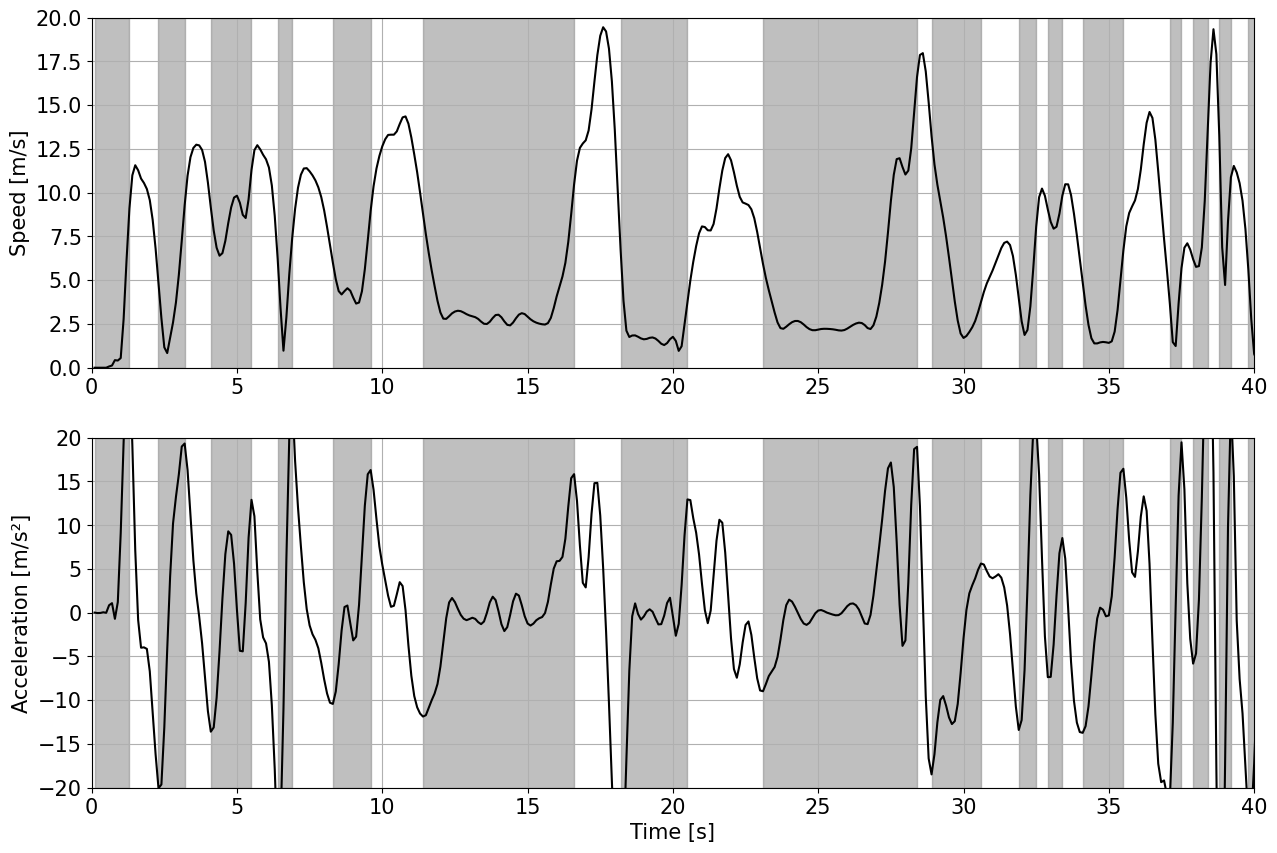

In [33]:
Postprocessor.plot_speeds_and_accels(ep_pred_traces, carry_records)

### Possession Score-Based Postprocessing

In [72]:
pp = Postprocessor(helper.traces, macro_pred, micro_pred)
pp.run(method="poss_score", thres_touch=0.2, thres_carry=0.7, evaluate=True)
pp.output

macro_acc: 0.5444
micro_pos_error: 6.8134


,carrier,ball_x,ball_y
0,A14,65.426371,37.98495
1,A14,65.387222,37.975099
2,A14,65.357861,37.975099
3,A14,65.3285,37.98495
4,A14,65.308926,38.004652
...,...,...,...
40318,NaN,92.888808,65.981119
40319,NaN,92.888808,65.981119
40320,NaN,92.888808,65.981119
40321,NaN,92.888808,65.981119


In [7]:
i0 = 0
i1 = 3000

pp.traces["carrier"] = pp.output["carrier"]
traces = pp.traces[i0:i1]
pred_traces = pp.pred_traces[i0:i1]
pp_traces = pp.output[i0:i1]

animator = TraceAnimator(
    trace_dict={"main": traces, "darkorange": pred_traces, "green": pp_traces},
    poss_probs=pp.pred_poss[i0:i1],
    show_episodes=True,
    show_events=True,
    annot_cols=["carrier", "player_poss_top3"]
)
anim = animator.run()

t0 = traces["time"].iloc[0]
t1 = traces["time"].iloc[-1]
t0_str = f"{int(t0 // 60):02d}.{int(t0 % 60):02d}"
t1_str = f"{int(t1 // 60):02d}.{int(t1 % 60):02d}"

if trace_dir == "metrica_traces":  # for Metrica data
    path = f"animations/metrica_{match_id}_{t0_str}-{t1_str}.mp4"
else:  # for Fitogether's GPS-event data
    path = f"animations/gps_{match_id}_{t0_str}-{t1_str}.mp4"

writer = animation.FFMpegWriter(fps=10)
anim.save(path, writer=writer)

In [7]:
episode = 1
ep_traces = pp.traces[pp.traces["episode"] == episode][:400].copy()
ep_poss_probs = macro_pred.loc[ep_traces.index].copy()
ep_poss_scores = pp.poss_scores.loc[ep_traces.index].copy()
ep_output = pp.output.loc[ep_traces.index].copy()

max_probs = ep_poss_probs.max()
valid_players = max_probs[max_probs > 0.2].index
valid_players

Index(['A03', 'B25', 'B15', 'B16', 'B17', 'B18', 'B20', 'B23'], dtype='object')

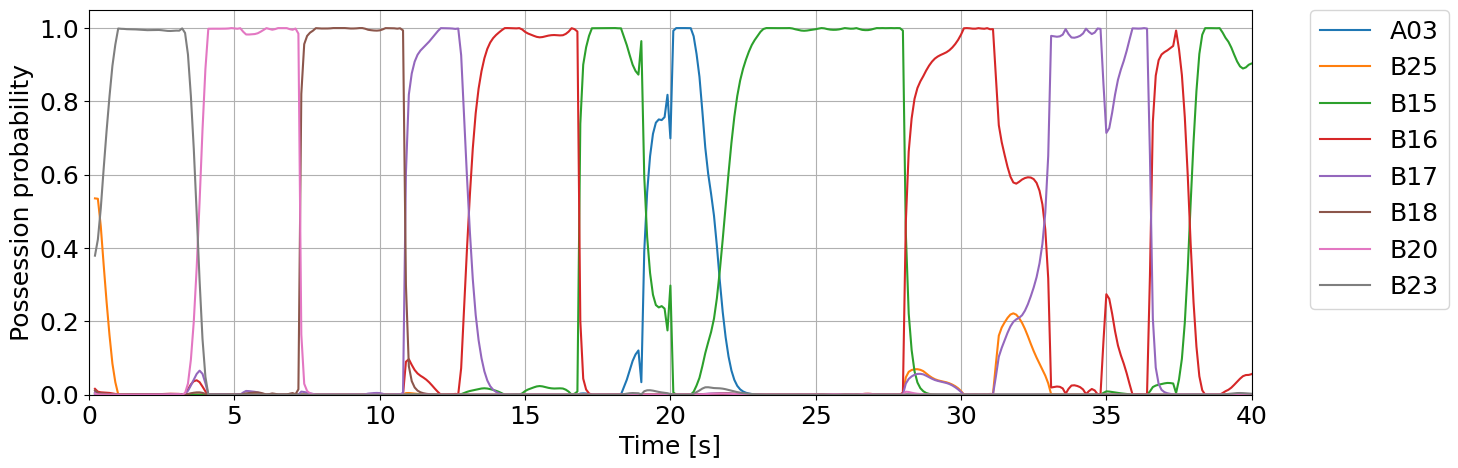

In [8]:
Postprocessor.plot_poss_values(ep_traces["time"], ep_poss_probs, valid_players, ylabel="Possession probability")

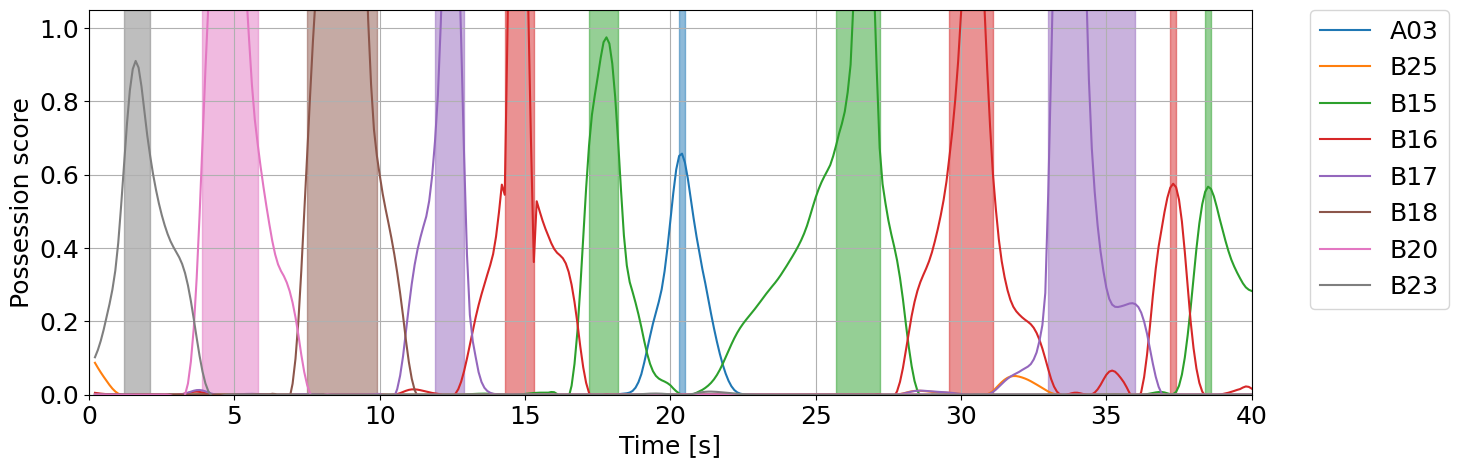

In [9]:
carry_records = Postprocessor.generate_carry_records(ep_output["carrier"])
Postprocessor.plot_poss_values(ep_traces["time"], ep_poss_scores, valid_players, carry_records=carry_records)

### Evaluating the Pass Detection Accuracy

In [54]:
true_passes = helper.generate_pass_records(pp.traces["frame"])
true_passes

,episode,start_frame,end_frame,passer,receiver,success
0,1,21,35,B23,B20,True
1,1,59,75,B20,B18,True
2,1,100,114,B18,B17,True
3,1,127,139,B17,B16,True
4,1,158,170,B16,B15,True
...,...,...,...,...,...,...
1100,75,54922,54933,A01,A05,True
1101,75,54934,54944,A05,A01,True
1102,76,55300,55971,A03,B25,False
1103,77,56004,56024,B25,B21,True


In [55]:
pred_passes = []

for episode in tqdm(pp.traces["episode"].unique()):
    if episode == 0:
        continue

    ep_traces = pp.traces[pp.traces["episode"] == episode]
    ep_output = pp.output.loc[ep_traces.index]
    carry_records = Postprocessor.generate_carry_records(ep_output["carrier"])

    for i in carry_records.index[:-1]:
        start_frame = carry_records.at[i, "end_idx"] + 2
        end_frame = carry_records.at[i + 1, "start_idx"]
        passer = carry_records.at[i, "carrier"]
        receiver = carry_records.at[i + 1, "carrier"]
        if not receiver.startswith("OUT"):
            success = passer[0] == receiver[0]
            pred_passes.append([episode, start_frame, end_frame, passer, receiver, success])

pass_cols = ["episode", "start_frame", "end_frame", "passer", "receiver", "success"]
pred_passes = pd.DataFrame(pred_passes, columns=pass_cols)
pred_passes

100%|██████████| 78/78 [00:00<00:00, 254.00it/s]


,episode,start_frame,end_frame,passer,receiver,success
0,1,24,50,B23,B20,True
1,1,63,75,B20,B18,True
2,1,103,113,B18,B17,True
3,1,128,141,B17,B16,True
4,1,163,174,B16,B15,True
...,...,...,...,...,...,...
1150,75,54939,54953,A05,B20,False
1151,76,55305,55338,A03,B17,False
1152,77,55958,55974,A09,B25,False
1153,77,55998,56033,B25,B21,True


##### (1) Pass detection accuracy

In [56]:
true_count = 0
true_passes["true_pos"] = False
pred_passes["true_pos"] = False

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    passer = true_passes.loc[i, "passer"]
    receiver = true_passes.loc[i, "receiver"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[(candidates["passer"] == passer) & (candidates["receiver"] == receiver)]
    if not matched.empty:
        true_count += 1
        true_passes.at[i, "true_pos"] = True
        pred_passes.at[matched.index[0], "true_pos"] = True

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 942
Precision: 0.8156
Recall: 0.8525
F1 score: 0.8336


##### (2) Passer detection accuracy

In [57]:
true_count = 0

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    passer = true_passes.loc[i, "passer"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[candidates["passer"] == passer]
    if not matched.empty:
        true_count += 1

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 1027
Precision: 0.8892
Recall: 0.9294
F1 score: 0.9088


##### (3) Receiver detection accuracy

In [58]:
true_count = 0

for i in true_passes.index:
    t_min = true_passes.loc[i, "start_frame"] - 20
    t_max = true_passes.loc[i, "end_frame"] + 20
    receiver = true_passes.loc[i, "receiver"]

    candidates = pred_passes[(pred_passes["start_frame"] >= t_min) & (pred_passes["end_frame"] <= t_max)]
    matched = candidates[candidates["receiver"] == receiver]
    if not matched.empty:
        true_count += 1

precision = true_count / len(pred_passes)
recall = true_count / len(true_passes)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Matched passes: {true_count}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1_score:.4f}")

Matched passes: 1005
Precision: 0.8701
Recall: 0.9095
F1 score: 0.8894


##### (4) Comparing pass statistics

In [59]:
players = true_passes["passer"].unique()
players.sort()
pass_stats = pd.DataFrame(index=players)

pass_stats["true_passes"] = true_passes.groupby("passer")["start_frame"].count()
pass_stats["pred_passes"] = pred_passes.groupby("passer")["start_frame"].count()
pass_stats["true_receives"] = true_passes.groupby("receiver")["start_frame"].count()
pass_stats["pred_receives"] = pred_passes.groupby("receiver")["start_frame"].count()
display(pass_stats)

print(metrics.r2_score(pass_stats["true_passes"], pass_stats["pred_passes"]).round(4))
print(metrics.r2_score(pass_stats["true_receives"], pass_stats["pred_receives"]).round(4))

,true_passes,pred_passes,true_receives,pred_receives
A01,54,58,53,60
A02,36,37,38,38
A03,38,41,41,43
A04,69,73,70,73
A05,93,83,88,81
A06,81,83,74,83
A07,61,59,64,59
A08,54,59,54,58
A09,65,70,65,66
A10,19,19,23,23


0.9723
0.9649


### Archive to be Deleted

In [103]:
phase_traces = helper.traces[helper.traces["phase"] == "(1, 1)"]
player_x_cols = [f"{p}_x" for p in helper.team1_players + helper.team2_players]

poss_labels = [c[:3] for c in phase_traces[player_x_cols].dropna(axis=1).columns] + ["OUT-L", "OUT-R", "OUT-B", "OUT-T"]
poss_dict = dict(zip(poss_labels, range(len(poss_labels))))
poss_dict["GOAL-L"] = len(poss_labels) - 4
poss_dict["GOAL-R"] = len(poss_labels) - 3

poss_df = pd.DataFrame(index=phase_traces.index)
poss_df["time"] = phase_traces["time"]
poss_df["pred_1st"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[0]])
poss_df["pred_2nd"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[1]])
poss_df["pred_3rd"] = phase_traces["player_poss_top3"].apply(lambda x: poss_dict[x[2]])
target_poss = phase_traces["event_player"].fillna(method="bfill").fillna(method="ffill")
poss_df["target"] = target_poss.apply(lambda x: poss_dict[x])

poss_df

,time,pred_1st,pred_2nd,pred_3rd,target
0,0.1,0,1,2,17
1,0.2,0,1,2,17
2,0.3,0,1,2,17
3,0.4,0,1,2,17
4,0.5,0,1,2,17
...,...,...,...,...,...
28285,2828.6,14,18,3,18
28286,2828.7,14,18,3,18
28287,2828.8,14,18,3,18
28288,2828.9,14,18,3,18


In [104]:
FRAME_DUR = 10

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.rcParams.update({"font.size": 15})

ax.set(xlim=(0, FRAME_DUR), ylim=(-1, len(poss_labels)))
ax.grid(color="grey")
ax.set_xlabel("time")
ax.set_yticks(range(len(poss_labels)), poss_labels)

plots = []
plots.append(plt.plot(poss_df["time"], poss_df["pred_1st"], marker="s", color="darkblue", label="pred_1st")[0])
plots.append(plt.plot(poss_df["time"], poss_df["pred_2nd"], marker="o", color="blue", label="pred_2nd")[0])
plots.append(plt.plot(poss_df["time"], poss_df["pred_3rd"], marker="o", color="skyblue", label="pred_3rd")[0])
plots.append(plt.plot(poss_df["time"], poss_df["target"], marker="*", color="red", label="target")[0])
ax.legend()

def animate(i):
    ax.set_xlim(2 * i, 2 * i + FRAME_DUR)

frames = (9000 - 10 * FRAME_DUR) // 20 + 1
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=200)
plt.close(fig)

writer = animation.FFMpegWriter(fps=5)
path = f"animations/player_poss_plots.mp4"
anim.save(path, writer=writer)